**Testing Models 1**

In this notebook, I will run a benchmark of the dataset with the Neural Network as described in Eric Wulff's thesis. I have split the entire procedure into several sections, beginning with data import, data preparation, training, visualizations, and testing.

I have provided several insights into the same as we proceed through the notebook. 

In [ ]:
#Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Attach the csv files prepared in the previous notebook and import then as DataFrames
gauss_x = pd.read_csv('/Dataset/Rank Gauss.csv')
standard_x = pd.read_csv('/Dataset/Standard.csv')

In [ ]:
#Split the datasets into the train, validation and test sets
gauss_x_train, gauss_x_test, standard_x_train, standard_x_test = train_test_split(gauss_x, standard_x, train_size=0.8,test_size=0.2, random_state=42)
gauss_x_train, gauss_x_valid, standard_x_train, standard_x_valid = train_test_split(gauss_x_train, standard_x_train, train_size=0.8,test_size=0.2, random_state=101)

In [ ]:
train_standard = standard_x_train
test_standard = standard_x_valid
train_gauss = gauss_x_train
test_gauss = gauss_x_valid

In [ ]:
train_standard.head()

,Unnamed: 0,E1,pt1,eta1,phi1
5560,5560,0.008512,-0.234876,1.097533,-0.985229
5217,5217,0.212163,0.740152,-0.525268,1.068588
1177,1177,0.709121,-1.343437,-2.125160,0.079273
6200,6200,-0.030566,0.699709,-0.156076,1.424401
2830,2830,-0.578546,-0.547662,-0.850619,-1.318161


In [ ]:
train_gauss.head()

,Unnamed: 0,E1,pt1,eta1,phi1
5560,5560,0.027559,-0.263620,1.069118,-0.789333
5217,5217,0.242156,0.760920,-0.517326,0.881419
1177,1177,0.736103,-1.303104,-2.125327,0.046459
6200,6200,-0.012443,0.719740,-0.134536,1.337830
2830,2830,-0.579210,-0.561604,-0.843895,-1.154171


In [ ]:
train_standard.pop('Unnamed: 0')
test_standard.pop('Unnamed: 0')
train_gauss.pop('Unnamed: 0')
test_gauss.pop('Unnamed: 0')

5118    5118
3626    3626
869      869
2877    2877
4460    4460
        ... 
946      946
5583    5583
4811    4811
649      649
5561    5561
Name: Unnamed: 0, Length: 993, dtype: int64

In [ ]:
#We have to manually convert the datasets to floats from doubles for training
for i in train_standard.columns:
  train_standard[i] = train_standard[i].astype('float32')
for i in test_standard.columns:
  test_standard[i] = test_standard[i].astype('float32')
for i in train_gauss.columns:
  train_gauss[i] = train_gauss[i].astype('float32')
for i in test_gauss.columns:
  test_gauss[i] = test_gauss[i].astype('float32')

#Save the mean and standard deviation of the datasets for plotting
train_mean_standard = train_standard.mean()
train_std_standard = train_standard.std()
train_mean_gauss = train_gauss.mean()
train_std_gauss = train_gauss.std()

We now plot the two datasets to perform few preliminary investigations

<Figure size 432x288 with 0 Axes>

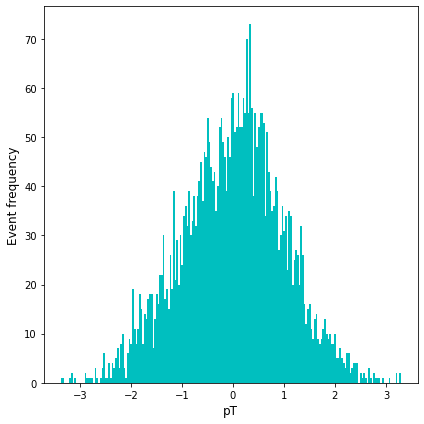

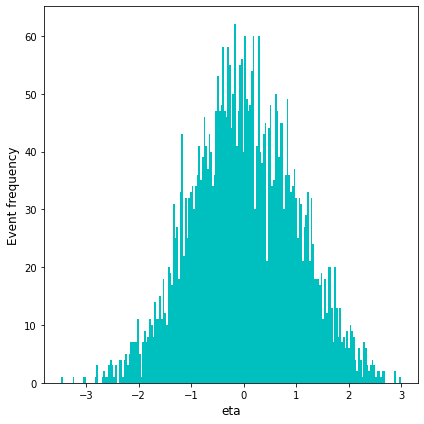

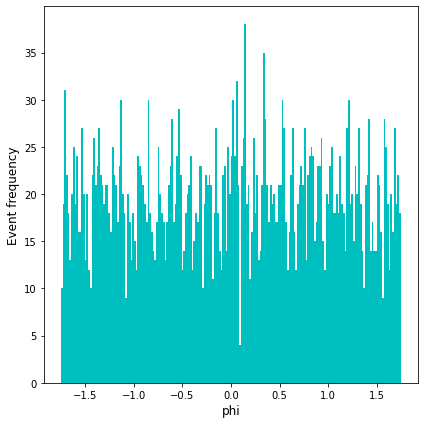

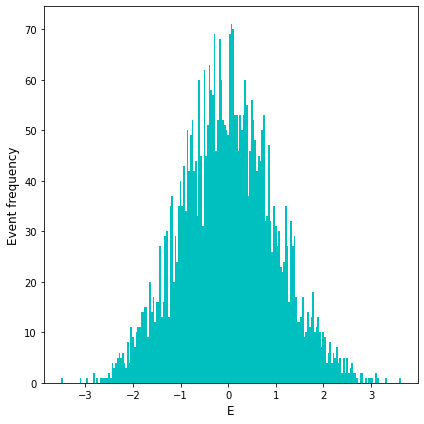

In [ ]:
#Plot of the standard dataset
plt.close('all')
x_labels = ['pT', 'eta', 'phi', 'E']
branches=["pt1","eta1","phi1","E1"]

%matplotlib inline
for i in np.arange(4):
    plt.figure(i + 4)
    plt.figure(figsize=(6,6))
    plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    n_hist_data, bin_edges, _ = plt.hist(train_standard[branches[i]], color='c', label='Input', alpha=1, bins=200)
    plt.xlabel(x_labels[i], size=12)
    plt.ylabel('Event frequency', size=12)
    plt.tight_layout()

<Figure size 432x288 with 0 Axes>

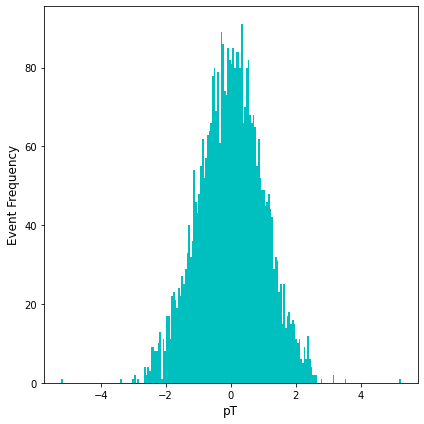

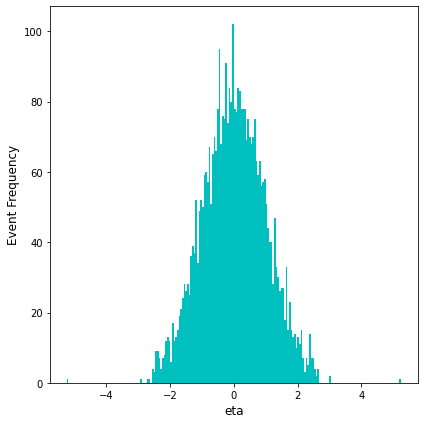

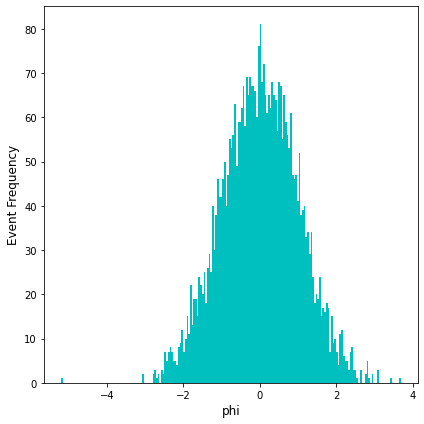

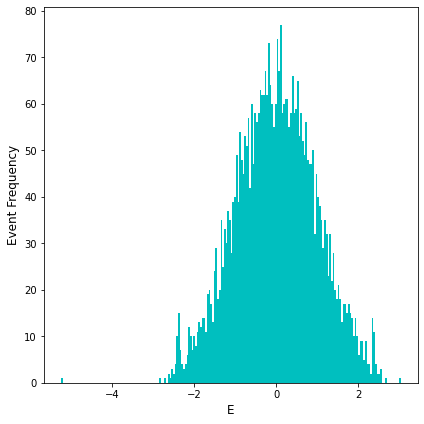

In [ ]:
for i in range(4):
    plt.figure(i + 4)
    plt.figure(figsize=(6,6))
    n_hist_data, bin_edges, _ = plt.hist(train_gauss[branches[i]], color='c', label='Input', alpha=1, bins=200)
    plt.xlabel(x_labels[i], size=12)
    plt.ylabel('Event Frequency', size=12)
    plt.tight_layout()

We now perfom all operations performed on the Train and Validation dataset, on the test dataset. 

In [ ]:
standard_x_test.pop('Unnamed: 0')
gauss_x_test.pop('Unnamed: 0')

for i in standard_x_test.columns:
  standard_x_test[i] = standard_x_test[i].astype('float32')
for i in gauss_x_test.columns:
  gauss_x_test[i] = gauss_x_test[i].astype('float32')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


**Data Preparation**

We now create the dataloaders that will be used during training. 

In [ ]:
import torch

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import data_block, basic_train, basic_data
#from fastai.callbacks import EarlyStoppingCallback

In [ ]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [ ]:
train_x_standard = train_standard
test_x_standard = test_standard
train_y_standard = train_x_standard  # y = x since we are building and AE
test_y_standard = test_x_standard

train_x_gauss = train_gauss
test_x_gauss = test_gauss
train_y_gauss = train_x_gauss  # Same reason as mentioned above
test_y_gauss = test_x_gauss

train_ds_standard = TensorDataset(torch.tensor(train_x_standard.values), torch.tensor(train_y_standard.values))
valid_ds_standard = TensorDataset(torch.tensor(test_x_standard.values), torch.tensor(test_y_standard.values))
train_ds_gauss = TensorDataset(torch.tensor(train_x_gauss.values), torch.tensor(train_y_gauss.values))
valid_ds_gauss = TensorDataset(torch.tensor(test_x_gauss.values), torch.tensor(test_y_gauss.values))

In [ ]:
train_dl_standard, valid_dl_standard = get_data(train_ds_standard, valid_ds_standard, bs=256)
train_dl_gauss, valid_dl_gauss = get_data(train_ds_gauss, valid_ds_gauss, bs=256)

db_standard = basic_data.DataBunch(train_dl_standard, valid_dl_standard)
db_gauss = basic_data.DataBunch(train_dl_gauss, valid_dl_gauss)

**Training**

We now import and train our models. Note here that I have completely segregated the definition and training of the standard and gauss models to avoid any sort of confusion. 

In [ ]:
%matplotlib inline

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from fastai import train as tr
import fastai

import matplotlib as mpl

torch.set_default_dtype(torch.float32)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.en1 = nn.Linear(4, 200)
        self.en2 = nn.Linear(200, 100)
        self.en3 = nn.Linear(100, 50)
        self.en4 = nn.Linear(50, 3)
        self.de1 = nn.Linear(3, 50)
        self.de2 = nn.Linear(50, 100)
        self.de3 = nn.Linear(100, 200)
        self.de4 = nn.Linear(200, 4)
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.en1(x)
        x = self.tanh(x)
        x = self.en2(x)
        x = self.tanh(x)
        x = self.en3(x)
        x = self.tanh(x)
        x = self.en4(x)
        return x

    def decode(self, x):
        x = self.tanh(x)
        x = self.de1(x)
        x = self.tanh(x)
        x = self.de2(x)
        x = self.tanh(x)
        x = self.de3(x)
        x = self.tanh(x)
        x = self.de4(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

**Standard Model Definition and Training**

In [ ]:
standard_model = AutoEncoder()
loss_func = nn.MSELoss()

In [ ]:
learn_standard = basic_train.Learner(data=db_standard, model=standard_model, loss_func=loss_func, wd=1e-6, bn_wd=False, true_wd=True)

In [ ]:
tr.lr_find(learn_standard)

epoch,train_loss,valid_loss,time
0,0.996821,#na#,00:00
1,0.993821,#na#,00:00
2,0.974639,#na#,00:00
3,0.805492,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


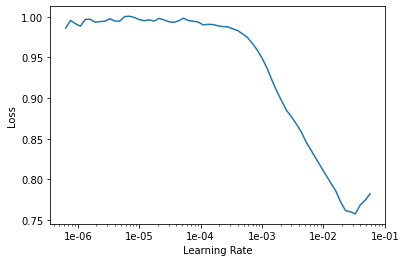

In [ ]:
learn_standard.recorder.plot()

In [ ]:
#standard_callback = EarlyStoppingCallback(learn_standard, monitor='valid_loss', patience = 10)

In [ ]:
lr_standard = 1e-2
learn_standard.fit_one_cycle(200, max_lr=lr_standard, 
                        callbacks = [])

epoch,train_loss,valid_loss,time
0,0.839618,0.598170,00:00
1,0.621154,0.401257,00:00
2,0.531537,0.367131,00:00
3,0.454774,0.253231,00:00
4,0.372121,0.178775,00:00
5,0.305045,0.142476,00:00
6,0.252615,0.118427,00:00
7,0.209451,0.094216,00:00
8,0.175015,0.080022,00:00
9,0.148241,0.072856,00:00


**Gaussian Model definition and training**

In [ ]:
gauss_model = AutoEncoder()
loss_func = nn.MSELoss()

In [ ]:
learn_gauss = basic_train.Learner(data=db_gauss, model=gauss_model, loss_func=loss_func, wd=1e-6, bn_wd=False, true_wd=True)

In [ ]:
tr.lr_find(learn_gauss)

epoch,train_loss,valid_loss,time
0,0.999067,#na#,00:00
1,0.999772,#na#,00:00
2,0.982491,#na#,00:00
3,0.797760,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


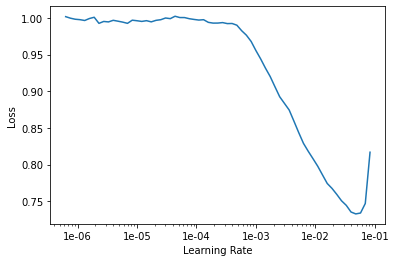

In [ ]:
learn_gauss.recorder.plot()

In [ ]:
#gaussian_callback = EarlyStoppingCallback(learn_gauss, monitor='valid_loss', patience = 10)

In [ ]:
lr_gauss = 1e-2
learn_gauss.fit_one_cycle(200, max_lr=lr_gauss, 
                        callbacks = [])

epoch,train_loss,valid_loss,time
0,0.866465,0.650636,00:00
1,0.664282,0.395645,00:00
2,0.525959,0.253949,00:00
3,0.406697,0.211817,00:00
4,0.331540,0.159241,00:00
5,0.275893,0.139688,00:00
6,0.232033,0.114551,00:00
7,0.194333,0.091730,00:00
8,0.163262,0.077347,00:00
9,0.138413,0.070007,00:00


**Visualization**

We now proceed to create plots of the different statistics we have genrated so far. 

1. Standard model plots

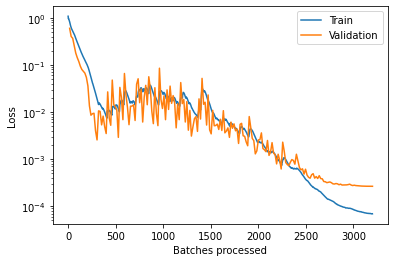

In [ ]:
#We begin by plotting the training/validation error vs batches processed 
learn_standard.recorder.plot_losses()
plt.yscale('log')

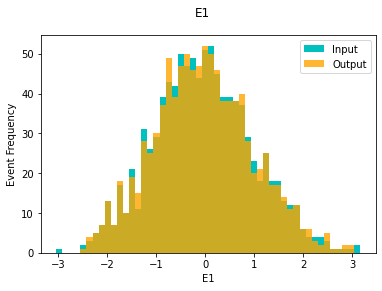

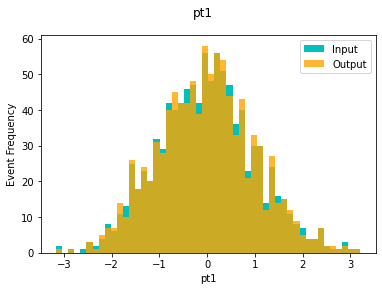

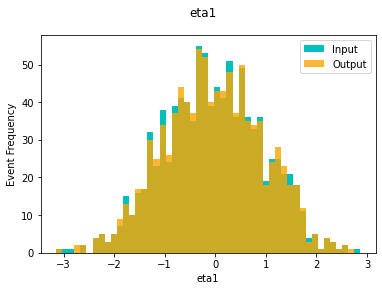

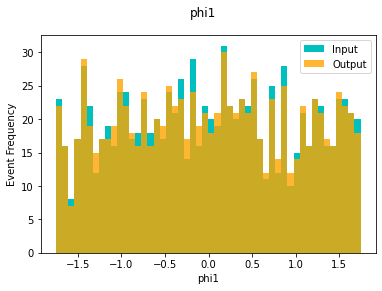

In [ ]:
#We plot the input vs output histograms to visualize the reconstruction errors
plt.close('all')
standard_model.to('cpu')

#Making predictions
data = torch.tensor(test_x_standard[0:1000].values)
pred = standard_model(data).detach().numpy()

# Histograms
for i in np.arange(4):
    plt.figure(i + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, i], color='c', label='Input', alpha=1, bins=50)
    n_hist_pred, _, _ = plt.hist(pred[:, i], color='orange', label='Output', alpha=0.8, bins=bin_edges)
    plt.suptitle(test_x_standard.columns[i])
    plt.xlabel(test_x_standard.columns[i])
    plt.ylabel('Event Frequency')
    plt.legend()

No handles with labels found to put in legend.


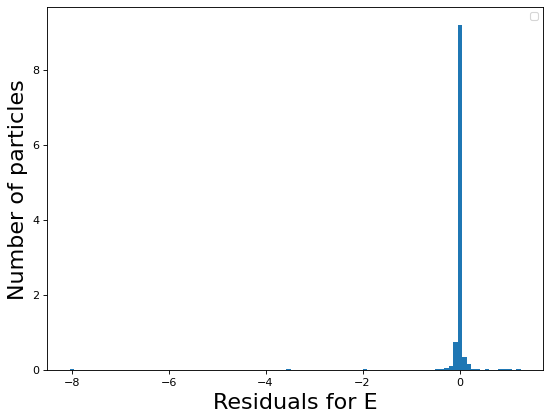

No handles with labels found to put in legend.


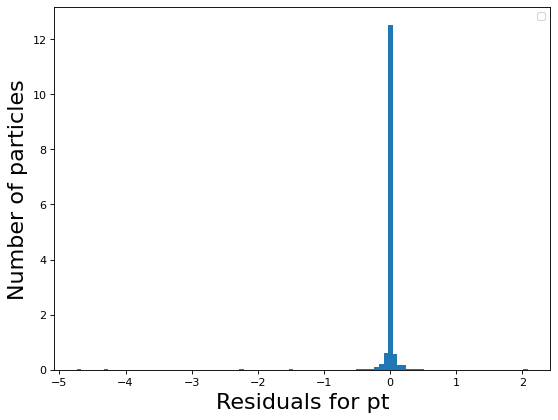

No handles with labels found to put in legend.


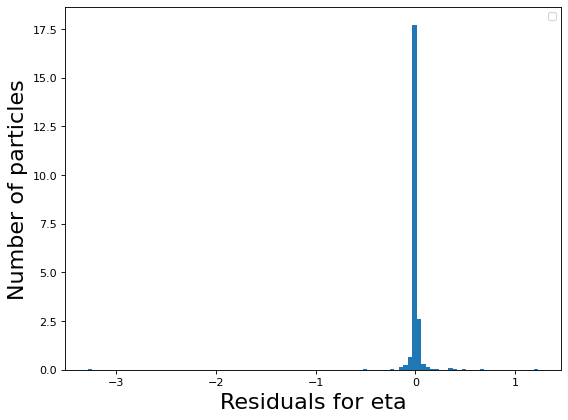

No handles with labels found to put in legend.


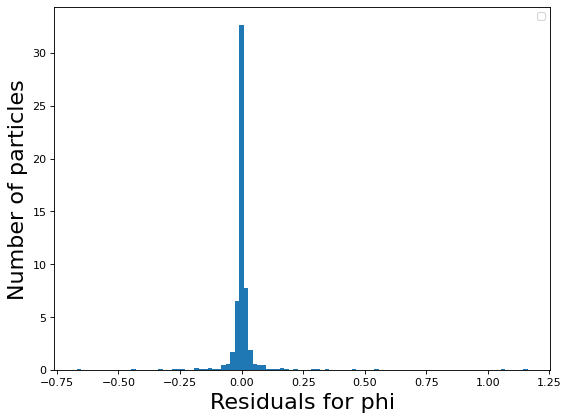

In [ ]:
#Next we make a histogram of the residuals
data = torch.tensor(test_x_standard[0:1000].values)
pred = standard_model(data).detach().numpy()

residuals = (pred - np.asarray(data)) /  np.asarray(data)
residuals = residuals.T

for i in np.arange(4):
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.hist(residuals[i], 100, density=True)
    plt.xlabel('Residuals for %s'%test_x_gauss.columns[i][:-1], fontsize=20) 
    plt.legend(fontsize=9)
    plt.ylabel('Number of particles', fontsize = 20)
    plt.show()

2. Gaussian Model

> We now make the same plots that we initially made for the standard model.



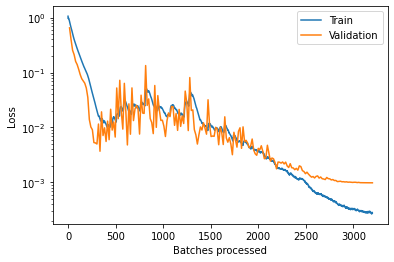

In [ ]:
learn_gauss.recorder.plot_losses()
plt.yscale('log')

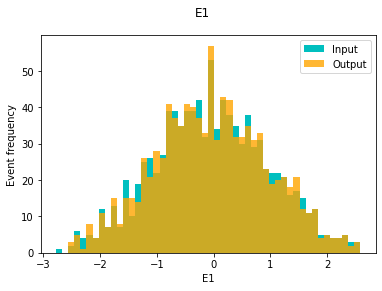

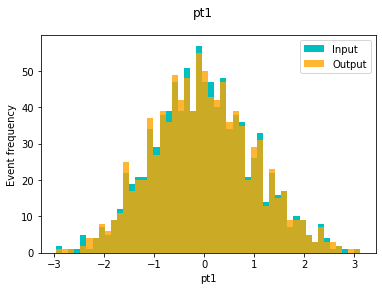

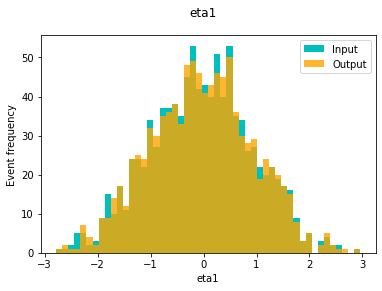

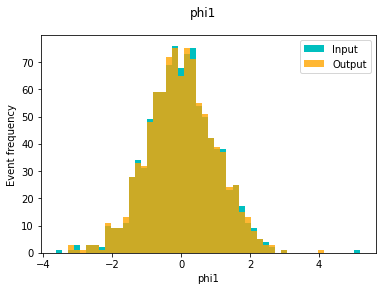

In [ ]:
plt.close('all')
gauss_model.to('cpu')

#Making predictions
data = torch.tensor(test_x_gauss[0:1000].values)
pred = gauss_model(data).detach().numpy()

# Histograms
data = torch.tensor(test_x_gauss[0:1000].values)
pred = gauss_model(data).detach().numpy()
for i in np.arange(4):
    plt.figure(i + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, i], color='c', label='Input', alpha=1, bins=50)
    n_hist_pred, _, _ = plt.hist(pred[:, i], color='orange', label='Output', alpha=0.8, bins=bin_edges)
    plt.suptitle(test_x_gauss.columns[i])
    plt.xlabel(test_x_gauss.columns[i])
    plt.ylabel('Event frequency')
    plt.legend()

In [ ]:
data = torch.tensor(train_x_gauss[0:1000].values)
pred = gauss_model(data).detach().numpy()

residuals = (pred - np.asarray(data)) /  np.asarray(data)
residuals = residuals.T

No handles with labels found to put in legend.


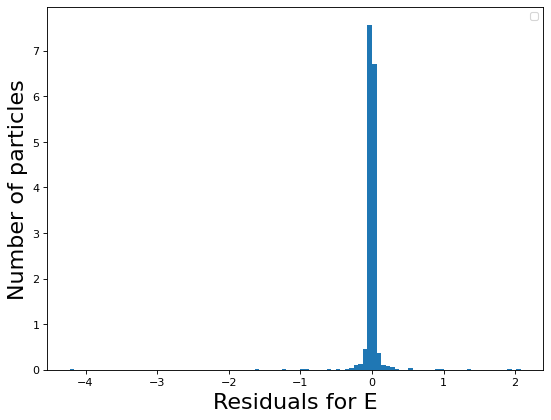

No handles with labels found to put in legend.


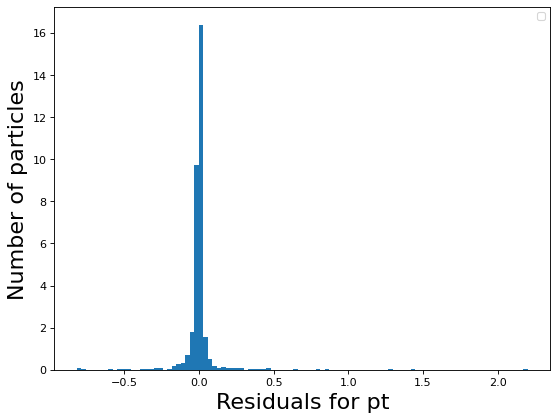

No handles with labels found to put in legend.


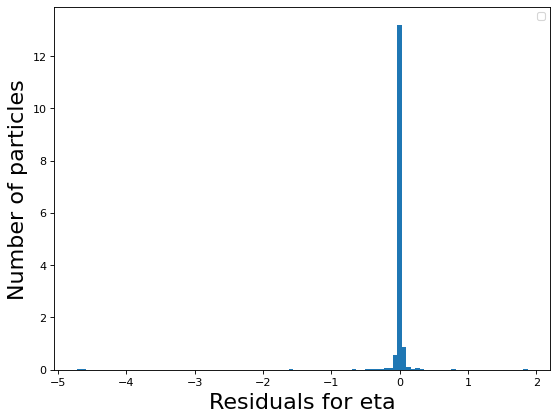

No handles with labels found to put in legend.


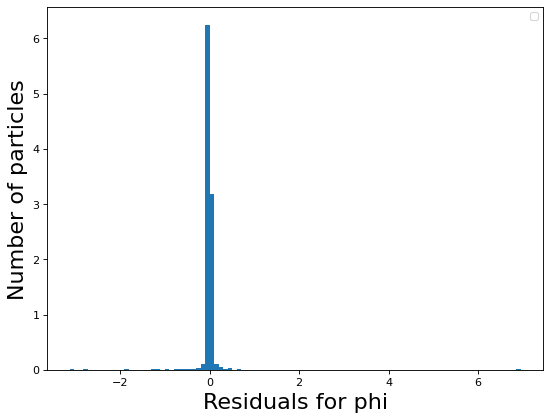

In [ ]:
for i in np.arange(4):
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.hist(residuals[i], 100, density=True)
    plt.xlabel('Residuals for %s'%test_x_gauss.columns[i][:-1], fontsize=20) 
    plt.legend(fontsize=9)
    plt.ylabel('Number of particles', fontsize = 20)
    plt.show()

**Testing**

We now run the two models against each other with the test sets to calculate their final benchmark score. 

In [ ]:
import torch.nn.functional as F

In [ ]:
def test(model, device, test_dataloader, plot_type):
  model.eval()
  loss = 0
  success = 0
  with torch.no_grad():
    for (X, y) in test_dataloader:
      X, y = X.to(device), y.to(device)
      pred_prob = model(X)
      loss += nn.MSELoss()(pred_prob, y).item()
  loss /= len(test_dataloader.dataset)
  print('\nTest dataset of {}: Overall Loss: {}'.format(plot_type, loss))

In [ ]:
test_ds = TensorDataset(torch.tensor(standard_x_test.values), torch.tensor(standard_x_test.values))
test_dataloader = DataLoader(test_ds, batch_size=64)
test(standard_model, 'cpu', test_dataloader, 'Standard model')


Test dataset of Standard model: Overall Loss: 2.8510077606577436e-06


In [ ]:
test_ds = TensorDataset(torch.tensor(gauss_x_test.values), torch.tensor(gauss_x_test.values))
test_dataloader = DataLoader(test_ds, batch_size=64)
test(gauss_model, 'cpu', test_dataloader, 'Gaussian Model')


Test dataset of Gaussian Model: Overall Loss: 1.5329884138749275e-05
